# Business Understanding

## Project Domain

Emas merupakan salah satu aset investasi paling stabil dan berharga, sering dijadikan lindung nilai (hedging) terhadap inflasi dan ketidakpastian ekonomi. Fluktuasi harga emas dipengaruhi oleh berbagai faktor ekonomi global dan gejolak pasar. Oleh karena itu, kemampuan untuk memprediksi harga emas secara akurat sangat penting bagi para pedagang (traders), investor, dan analis pasar.

## Problem Statements

 Harga Emas Sangat Fluktuatif
Harga emas dapat berubah setiap hari, bahkan setiap jam, dipengaruhi oleh:
*  Ketidakpastian geopolitik (perang, konflik, dll)
*   Kebijakan suku bunga dari bank sentral seperti The Fed
*  Inflasi dan deflasi

2. Kesulitan Menentukan Waktu Transaksi yang Tepat.
Pedagang emas—baik individu maupun institusi—berusaha membeli emas saat harga rendah dan menjual saat harga tinggi. Namun:
* Perubahan tren harga tidak selalu linier atau mudah dikenali.
* Tanpa pola atau prediksi yang jelas, keputusan pembelian/penjualan cenderung berbasis spekulasi.

3. Kurangnya Dukungan dari Sistem Prediksi Berbasis Data
Banyak pedagang tradisional masih mengandalkan:
* Intuisi pribadi
* Rumor pasar
* Analisis manual terhadap grafik harga



## Goals

1.   Membangun model prediksi harga emas jangka pendek berdasarkan data historis dan indikator ekonomi.
2.   Memberikan wawasan kepada investor dan analis untuk pengambilan keputusan yang lebih akurat.
3. Mengurangi ketergantungan pada spekulasi dan asumsi subjektif dalam memprediksi harga emas.





## Solution Statements

1. Model mampu memprediksi harga emas dengan akurasi tinggi (misalnya RMSE rendah).

2. Visualisasi tren dan prediksi harga yang mudah dipahami oleh pihak non-teknis.

3. Dapat dijadikan dasar pengambilan keputusan dalam strategi investasi.



# Data Understanding

## Import data dari kaggle

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"elitaarini","key":"1c638217b24cfa88c5cc1350d8ec0581"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [3]:
!kaggle datasets download -d farzadnekouei/gold-price-10-years-20132023

Dataset URL: https://www.kaggle.com/datasets/farzadnekouei/gold-price-10-years-20132023
License(s): unknown
  0% 0.00/46.3k [00:00<?, ?B/s]
100% 46.3k/46.3k [00:00<00:00, 201MB/s]


In [4]:
!mkdir gold-price-10-years-20132023
!unzip gold-price-10-years-20132023.zip -d gold-price-10-years-20132023
!ls gold-price-10-years-20132023

Archive:  gold-price-10-years-20132023.zip
  inflating: gold-price-10-years-20132023/Gold Price (2013-2023).csv  
'Gold Price (2013-2023).csv'


## Import Library yang dibutuhkan

In [105]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

In [6]:
df = pd.read_csv('/content/gold-price-10-years-20132023/Gold Price (2013-2023).csv')

In [7]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%
3,12/27/2022,"1,823.10","1,808.20","1,841.90","1,808.00",159.62K,0.74%
4,12/26/2022,"1,809.70","1,805.80","1,811.95","1,805.55",NaN,0.30%


## Exploratory Data Analysis

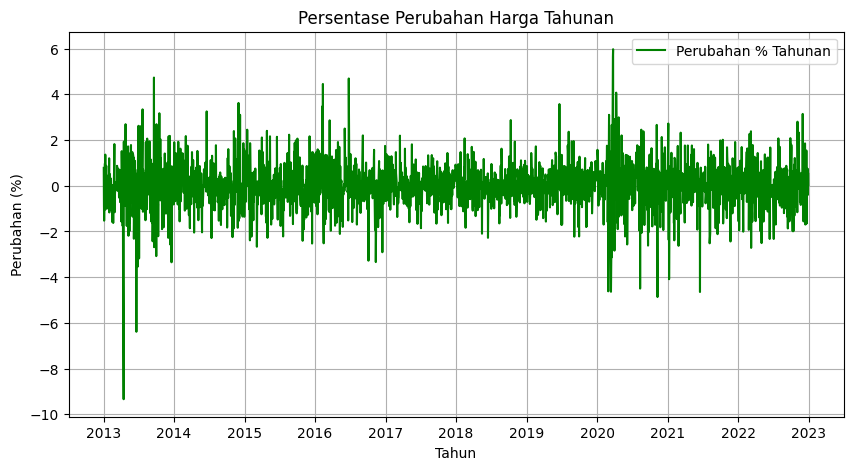

In [39]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Perubahan Persentase Harian (Change %)
df['Change %'] = df['Change %'].astype(str).str.replace('%', '').astype(float)

plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Change %'], label='Perubahan % Tahunan', color='green')
plt.title('Persentase Perubahan Harga Tahunan')
plt.xlabel('Tahun')
plt.ylabel('Perubahan (%)')
plt.grid(True)
plt.legend()
plt.show()

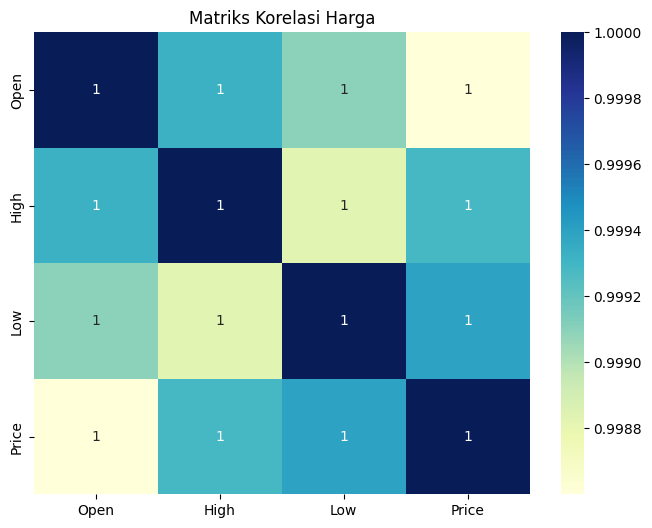

In [50]:
# Convert relevant columns to numeric, handling commas
for col in ['Open', 'High', 'Low', 'Price']:
    df[col] = pd.to_numeric(df[col].str.replace(',', ''), errors='coerce')

plt.figure(figsize=(8, 6))
sns.heatmap(df[['Open', 'High', 'Low', 'Price']].corr(), annot=True, cmap='YlGnBu')
plt.title('Matriks Korelasi Harga')
plt.show()

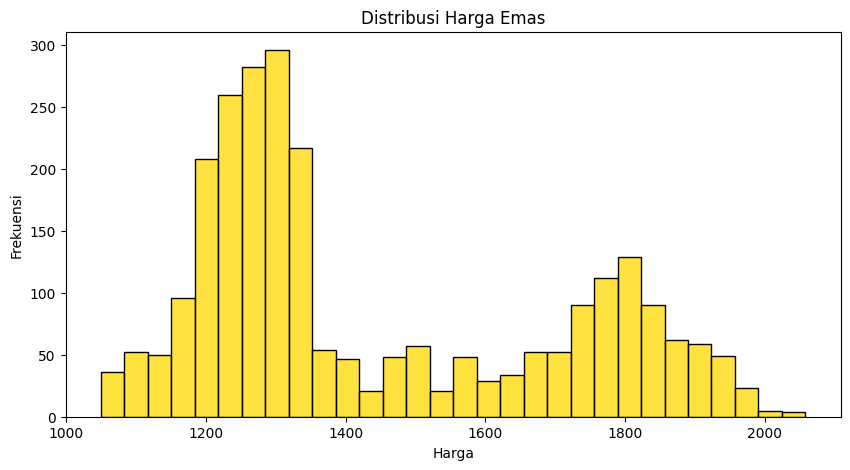

In [51]:
# Menggunakan histogram untuk melihat distribusi harga emas
plt.figure(figsize=(10, 5))
sns.histplot(df['Price'], bins=30, color='gold')
plt.title('Distribusi Harga Emas')
plt.xlabel('Harga')
plt.ylabel('Frekuensi')
plt.show()

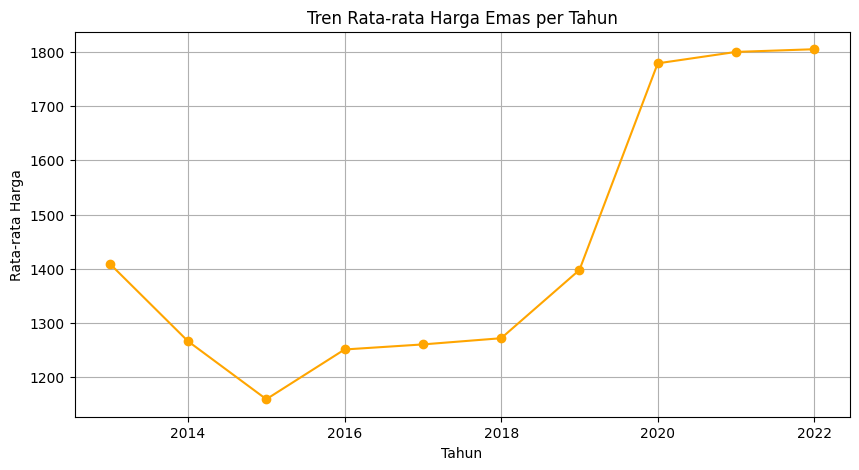

In [68]:
# Mengelompokkan data berdasarkan tahun dan menghitung rata-rata harga
yearly_avg_price = df.groupby(df['Date'].dt.year)['Price'].mean()

plt.figure(figsize=(10, 5))
yearly_avg_price.plot(kind='line', marker='o', color='orange')
plt.title('Tren Rata-rata Harga Emas per Tahun')
plt.xlabel('Tahun')
plt.ylabel('Rata-rata Harga')
plt.grid(True)
plt.show()

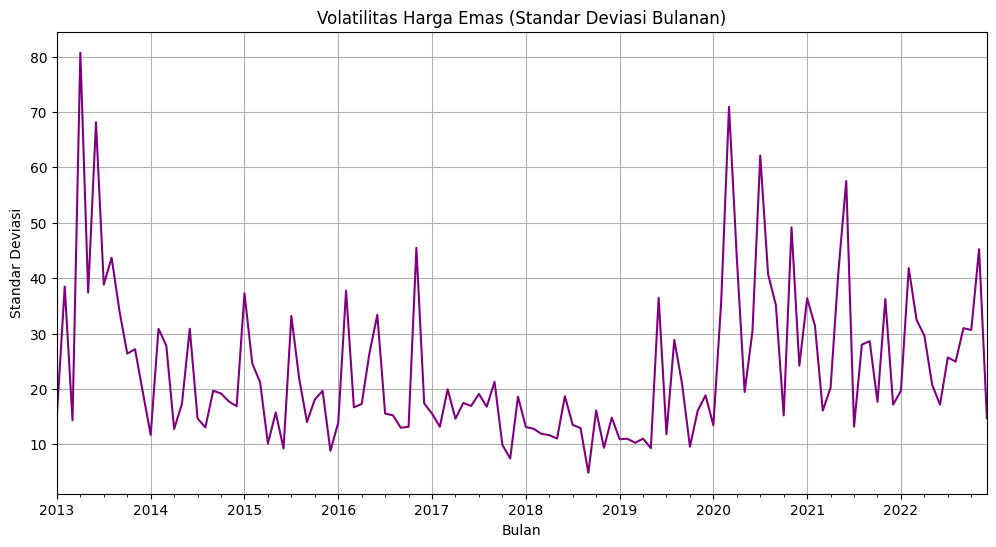

In [71]:
# Menghitung standar deviasi harga emas dalam periode waktu tertentu
# Misalnya, per bulan
monthly_std_price = df.groupby(pd.PeriodIndex(df['Date'], freq='M'))['Price'].std()

plt.figure(figsize=(12, 6))
monthly_std_price.plot(kind='line', color='purple')
plt.title('Volatilitas Harga Emas (Standar Deviasi Bulanan)')
plt.xlabel('Bulan')
plt.ylabel('Standar Deviasi')
plt.grid(True)
plt.show()

# Note : default plotting pandas untuk PeriodIndex dengan rentang yang panjang.
# Plot menampilkan tahun sebagai penanda interval besar, tetapi data yang diplot per bulan.



# Data Preparation

In [72]:
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)

In [73]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [74]:
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

In [75]:
df.head()

,Date,Price,Open,High,Low,Year
0,2013-01-02,1689.9,1675.8,1695.0,1672.1,2013.0
1,2013-01-03,1675.6,1688.0,1689.3,1664.3,2013.0
2,2013-01-04,1649.9,1664.4,1664.4,1630.0,2013.0
3,2013-01-07,1647.2,1657.3,1663.8,1645.3,2013.0
4,2013-01-08,1663.2,1651.5,1662.6,1648.8,2013.0


In [76]:
df.duplicated().sum()

np.int64(0)

In [77]:
df.isnull().sum().sum()

np.int64(0)

In [79]:
fig = px.line(y=df.Price, x=df.Date)
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title='Date',yaxis_title="Scaled Price",
                  title={'text': "Gold Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')
fig.show()

In [80]:
# Splitting Data to Training & Test Sets
test_size = df[df.Date.dt.year==2022].shape[0]
test_size

260

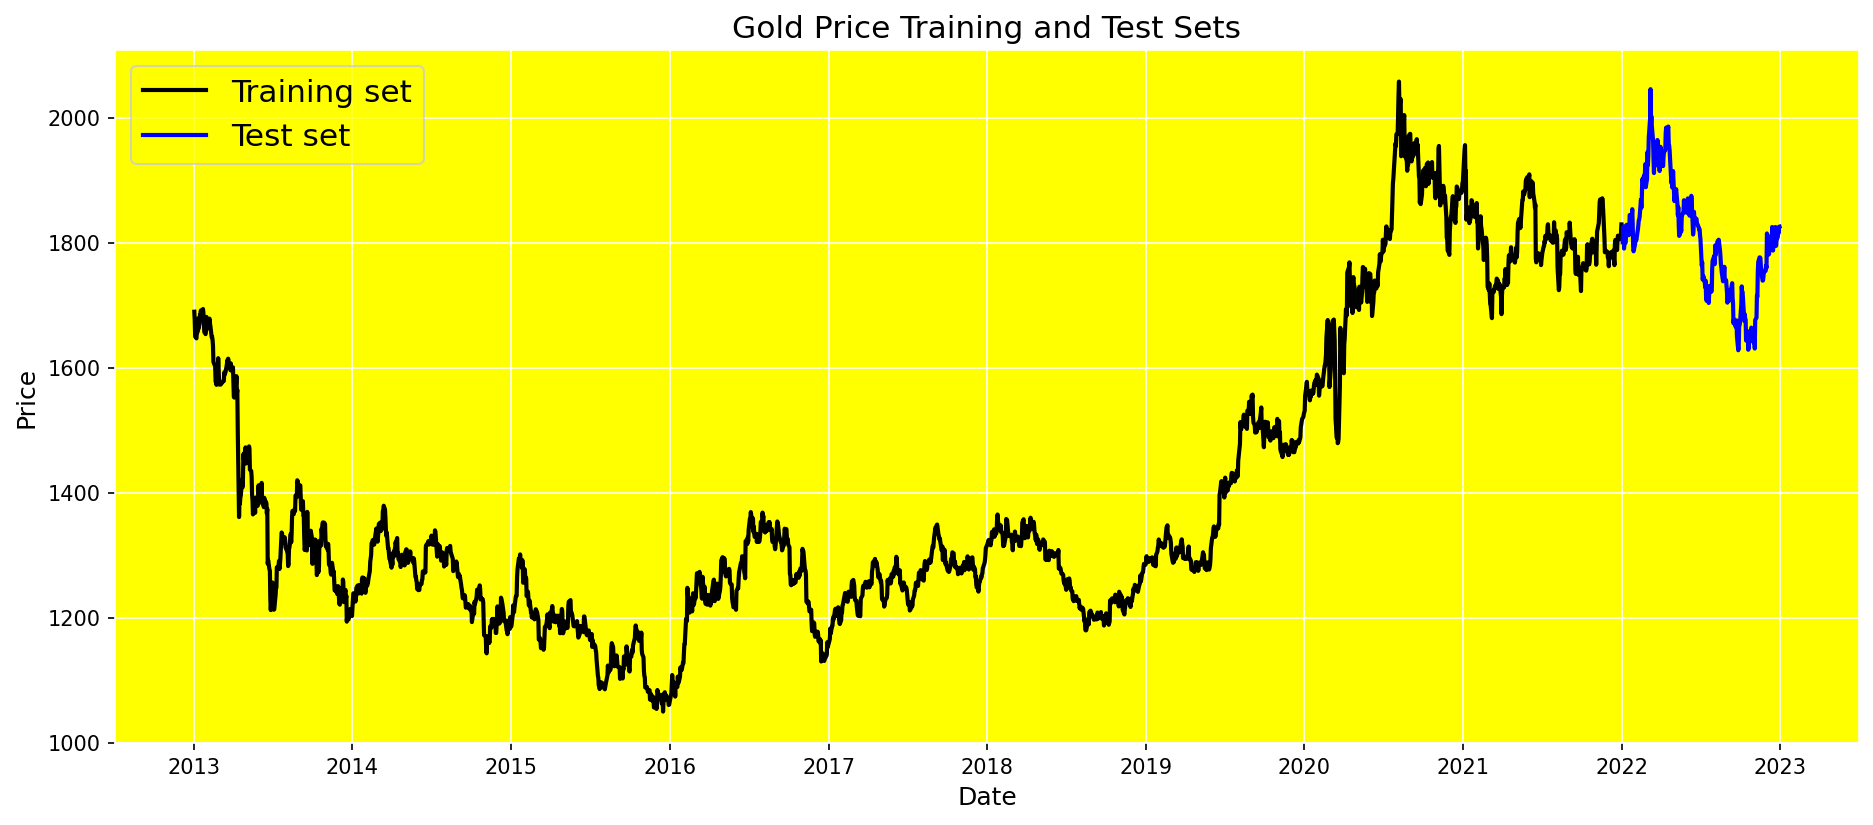

In [81]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df.Date[:-test_size], df.Price[:-test_size], color='black', lw=2)
plt.plot(df.Date[-test_size:], df.Price[-test_size:], color='blue', lw=2)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [82]:
# Data Scaling
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1,1))

MinMaxScaler()

In [83]:
window_size = 60

In [84]:
train_data = df.Price[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [85]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [87]:
test_data = df.Price[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [88]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

In [89]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [90]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [91]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (2263, 60, 1)
y_train Shape:  (2263, 1)
X_test Shape:   (260, 60, 1)
y_test Shape:   (260, 1)


# Modeling

In [111]:
def define_model():
    input1 = Input(shape=(window_size, 1))
    x = LSTM(64, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)(input1)
    x = Dropout(0.2)(x)
    x = LSTM(64, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(64, activation='tanh', recurrent_activation='sigmoid')(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=dnn_output)
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    return model

In [112]:
model = define_model()
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0177 - val_loss: 0.0060
Epoch 2/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 3/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0022 - val_loss: 0.0083
Epoch 4/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 5/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 6/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 7/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 8/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 9/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 10/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012 - val_loss: 8.8176e-04
Epoch 11/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 12/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/

# Evaluation

In [95]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.6211e-04
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [96]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [97]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.0007201486732810736
Test MAPE: 0.027954644671903124
Test Accuracy: 0.9720453553280969


# Deployment

## Model Simulation

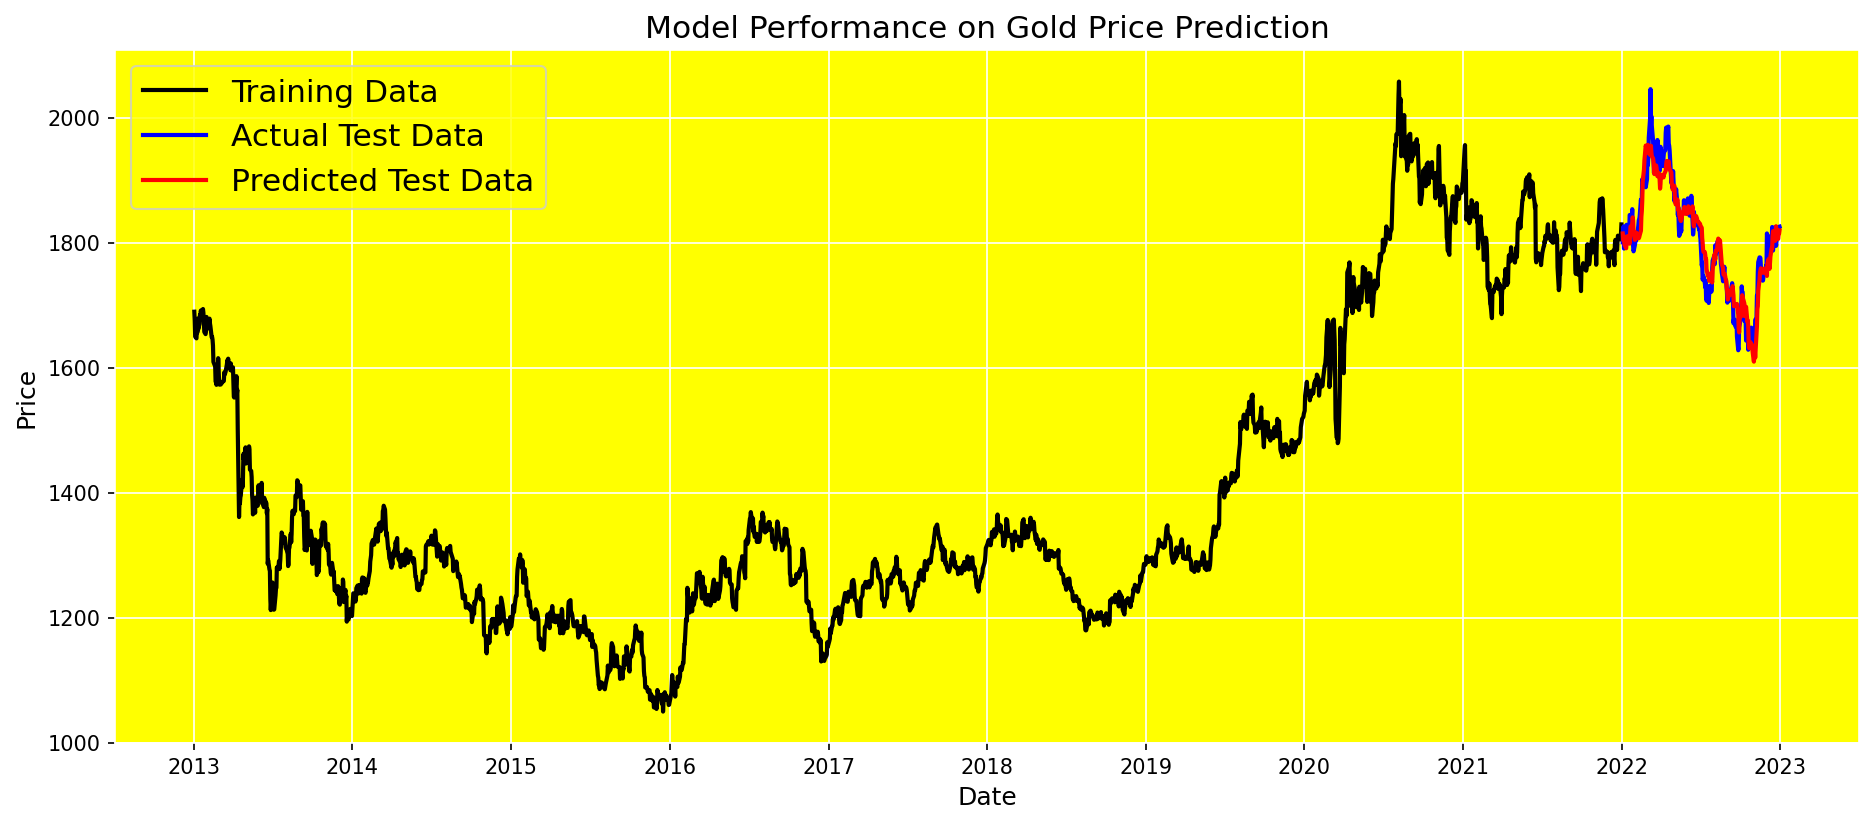

In [98]:
# Dengan asumsi 'y_test' berisi nilai target berskala untuk set pengujian
y_test_true = scaler.inverse_transform(y_test) # membalikkan skala untuk mendapatkan harga aktual
y_test_pred = scaler.inverse_transform(y_pred)

plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

## Save Model

In [113]:
model.save('model_gold_price.h5')

In [ ]:

import tensorflow as tf

# Muat ulang model dari file .h5
model = tf.keras.models.load_model("model_gold_price.h5", compile=False)

# Ubah model ke format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Optimasi ukuran model (opsional)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Konversi ke TFLite
try:
    tflite_model = converter.convert()
    # Simpan ke file
    with open("model_gold_price.tflite", "wb") as f:
        f.write(tflite_model)
    print("✅ Model berhasil dikonversi ke .tflite dan disimpan.")
except Exception as e:
    print("❌ Gagal mengonversi model ke .tflite:")
    import traceback
    traceback.print_exc()


In [115]:
model = tf.keras.models.load_model("model_gold_price.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open("model_gold_price.tflite", "wb") as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpdk6ylef_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 60, 1), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132610742274960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132610427830928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132610427831504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132610427831312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132610427831696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132610427840912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132610743252560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132610743252752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132610743248528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132610743253520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132610743242576: Te

ConverterError: Could not translate MLIR to FlatBuffer.<unknown>:0: error: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_2_1/lstm_6_1/CudnnRNNV3@__inference_function_178738"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_178801"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.CudnnRNNV3' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_2_1/lstm_6_1/CudnnRNNV3@__inference_function_178738"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_178801"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): see current operation: %1:5 = "tf.CudnnRNNV3"(%arg0, %arg1, %arg2, %arg3, %arg4) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x60x1xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<17152xf32>, tensor<?xi32>) -> (tensor<?x60x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_2_1/lstm_6_1/CudnnRNNV3@__inference_function_178738"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_178801"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): Error code: ERROR_NEEDS_CUSTOM_OPS
<unknown>:0: error: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_2_1/lstm_7_1/CudnnRNNV3@__inference_function_178738"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_178801"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.CudnnRNNV3' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_2_1/lstm_7_1/CudnnRNNV3@__inference_function_178738"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_178801"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): see current operation: %1:5 = "tf.CudnnRNNV3"(%arg0, %arg1, %arg2, %arg3, %arg4) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x60x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<33280xf32>, tensor<?xi32>) -> (tensor<?x60x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_2_1/lstm_7_1/CudnnRNNV3@__inference_function_178738"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_178801"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): Error code: ERROR_NEEDS_CUSTOM_OPS
<unknown>:0: error: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_2_1/lstm_8_1/CudnnRNNV3@__inference_function_178738"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_178801"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.CudnnRNNV3' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_2_1/lstm_8_1/CudnnRNNV3@__inference_function_178738"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_178801"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): see current operation: %1:5 = "tf.CudnnRNNV3"(%arg0, %arg1, %arg2, %arg3, %arg4) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x60x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<33280xf32>, tensor<?xi32>) -> (tensor<?x60x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_2_1/lstm_8_1/CudnnRNNV3@__inference_function_178738"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_178801"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): Error code: ERROR_NEEDS_CUSTOM_OPS
<unknown>:0: error: failed while converting: 'main': 
Some ops in the model are custom ops, See instructions to implement custom ops: https://www.tensorflow.org/lite/guide/ops_custom 
Custom ops: CudnnRNNV3
Details:
	tf.CudnnRNNV3(tensor<?x60x1xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<17152xf32>, tensor<?xi32>) -> (tensor<?x60x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>) : {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false}
	tf.CudnnRNNV3(tensor<?x60x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<33280xf32>, tensor<?xi32>) -> (tensor<?x60x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>) : {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false}

<unknown>:0: note: see current operation: 
"func.func"() <{arg_attrs = [{tf_saved_model.index_path = ["input_layer_2"]}], function_type = (tensor<?x60x1xf32>) -> tensor<?x1xf32>, res_attrs = [{tf_saved_model.index_path = ["output_0"]}], sym_name = "main"}> ({
^bb0(%arg0: tensor<?x60x1xf32>):
  %0 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<33280xf32>}> : () -> tensor<33280xf32>
  %1 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<33280xf32>}> : () -> tensor<33280xf32>
  %2 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<17152xf32>}> : () -> tensor<17152xf32>
  %3 = "arith.constant"() <{value = dense<0.0803969949> : tensor<1xf32>}> : () -> tensor<1xf32>
  %4 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<32xf32>}> : () -> tensor<32xf32>
  %5 = "arith.constant"() <{value = dense<64> : tensor<i32>}> : () -> tensor<i32>
  %6 = "arith.constant"() <{value = dense<0.000000e+00> : tensor<f32>}> : () -> tensor<f32>
  %7 = "arith.constant"() <{value = dense<1> : tensor<1xi32>}> : () -> tensor<1xi32>
  %8 = "arith.constant"() <{value = dense<0> : tensor<1xi32>}> : () -> tensor<1xi32>
  %9 = "arith.constant"() <{value = dense<1> : tensor<i32>}> : () -> tensor<i32>
  %10 = "arith.constant"() <{value = dense<60> : tensor<i32>}> : () -> tensor<i32>
  %11 = "arith.constant"() <{value = dense<[-1, 64]> : tensor<2xi32>}> : () -> tensor<2xi32>
  %12 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<1x32xf32>}> : () -> tensor<1x32xf32>
  %13 = "tfl.pseudo_qconst"() <{qtype = tensor<32x64x!quant.uniform<i8<-127:127>:f32:0, {0.0027591015879563459,0.0031064403808023049,0.0020732443163714071,0.0020629723710337963,0.0025287990964303806,0.0030625626796812523,0.0035873362867850957,0.0024347202045711005,0.0020129086933736726,0.0023236492956717181,0.0024832714730360379,0.0023955815420376035,0.0028624680098586195,0.0026609648869732232,0.0019431203369080551,0.0019579859465125977,0.002311932055030282,0.0021247408521456982,0.0022169938237648311,0.0022211323572894721,0.0024807854430882012,0.0029627694858340766,0.0024266794441253183,0.0022889286514342299,0.0021231460759020227,0.0024973555343357598,0.0020185495455434005,0.0023842289691834938,0.0019772989074076253,0.0021528022026452492,0.0029416288447192333,0.0025284832387458623}>>, value = dense_resource<__elided__> : tensor<32x64xi8>}> : () -> tensor<32x64x!quant.uniform<i8<-127:127>:f32:0, {0.0027591015879563459,0.0031064403808023049,0.0020732443163714071,0.0020629723710337963,0.0025287990964303806,0.0030625626796812523,0.0035873362867850957,0.0024347202045711005,0.0020129086933736726,0.0023236492956717181,0.0024832714730360379,0.0023955815420376035,0.0028624680098586195,0.0026609648869732232,0.0019431203369080551,0.0019579859465125977,0.002311932055030282,0.0021247408521456982,0.0022169938237648311,0.0022211323572894721,0.0024807854430882012,0.0029627694858340766,0.0024266794441253183,0.0022889286514342299,0.0021231460759020227,0.0024973555343357598,0.0020185495455434005,0.0023842289691834938,0.0019772989074076253,0.0021528022026452492,0.0029416288447192333,0.0025284832387458623}>>
  %14 = "tfl.shape"(%arg0) : (tensor<?x60x1xf32>) -> tensor<3xi32>
  %15 = "tfl.strided_slice"(%14, %8, %7, %7) <{begin_mask = 0 : i32, ellipsis_mask = 0 : i32, end_mask = 0 : i32, new_axis_mask = 0 : i32, offset = false, shrink_axis_mask = 1 : i32}> : (tensor<3xi32>, tensor<1xi32>, tensor<1xi32>, tensor<1xi32>) -> tensor<i32>
  %16 = "tfl.pack"(%15, %5) <{axis = 0 : i32, values_count = 2 : i32}> : (tensor<i32>, tensor<i32>) -> tensor<2xi32>
  %17 = "tfl.fill"(%16, %6) : (tensor<2xi32>, tensor<f32>) -> tensor<?x64xf32>
  %18 = "tfl.expand_dims"(%17, %9) : (tensor<?x64xf32>, tensor<i32>) -> tensor<?x1x64xf32>
  %19 = "tfl.reshape"(%15, %7) : (tensor<i32>, tensor<1xi32>) -> tensor<1xi32>
  %20 = "tfl.fill"(%19, %10) : (tensor<1xi32>, tensor<i32>) -> tensor<?xi32>
  %21:5 = "tfl.custom_tf"(%arg0, %18, %18, %2, %20) ({
  ^bb0(%arg11: tensor<?x60x1xf32>, %arg12: tensor<?x1x64xf32>, %arg13: tensor<?x1x64xf32>, %arg14: tensor<17152xf32>, %arg15: tensor<?xi32>):
    %43:5 = "tf.CudnnRNNV3"(%arg11, %arg12, %arg13, %arg14, %arg15) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x60x1xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<17152xf32>, tensor<?xi32>) -> (tensor<?x60x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
    "tfl.yield"(%43#0, %43#1, %43#2, %43#3, %43#4) : (tensor<?x60x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>) -> ()
  }) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x60x1xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<17152xf32>, tensor<?xi32>) -> (tensor<?x60x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
  %22 = "tfl.shape"(%21#0) : (tensor<?x60x64xf32>) -> tensor<3xi32>
  %23 = "tfl.strided_slice"(%22, %8, %7, %7) <{begin_mask = 0 : i32, ellipsis_mask = 0 : i32, end_mask = 0 : i32, new_axis_mask = 0 : i32, offset = false, shrink_axis_mask = 1 : i32}> : (tensor<3xi32>, tensor<1xi32>, tensor<1xi32>, tensor<1xi32>) -> tensor<i32>
  %24 = "tfl.pack"(%23, %5) <{axis = 0 : i32, values_count = 2 : i32}> : (tensor<i32>, tensor<i32>) -> tensor<2xi32>
  %25 = "tfl.fill"(%24, %6) : (tensor<2xi32>, tensor<f32>) -> tensor<?x64xf32>
  %26 = "tfl.expand_dims"(%25, %9) : (tensor<?x64xf32>, tensor<i32>) -> tensor<?x1x64xf32>
  %27 = "tfl.reshape"(%23, %7) : (tensor<i32>, tensor<1xi32>) -> tensor<1xi32>
  %28 = "tfl.fill"(%27, %10) : (tensor<1xi32>, tensor<i32>) -> tensor<?xi32>
  %29:5 = "tfl.custom_tf"(%21#0, %26, %26, %1, %28) ({
  ^bb0(%arg6: tensor<?x60x64xf32>, %arg7: tensor<?x1x64xf32>, %arg8: tensor<?x1x64xf32>, %arg9: tensor<33280xf32>, %arg10: tensor<?xi32>):
    %42:5 = "tf.CudnnRNNV3"(%arg6, %arg7, %arg8, %arg9, %arg10) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x60x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<33280xf32>, tensor<?xi32>) -> (tensor<?x60x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
    "tfl.yield"(%42#0, %42#1, %42#2, %42#3, %42#4) : (tensor<?x60x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>) -> ()
  }) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x60x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<33280xf32>, tensor<?xi32>) -> (tensor<?x60x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
  %30 = "tfl.shape"(%29#0) : (tensor<?x60x64xf32>) -> tensor<3xi32>
  %31 = "tfl.strided_slice"(%30, %8, %7, %7) <{begin_mask = 0 : i32, ellipsis_mask = 0 : i32, end_mask = 0 : i32, new_axis_mask = 0 : i32, offset = false, shrink_axis_mask = 1 : i32}> : (tensor<3xi32>, tensor<1xi32>, tensor<1xi32>, tensor<1xi32>) -> tensor<i32>
  %32 = "tfl.pack"(%31, %5) <{axis = 0 : i32, values_count = 2 : i32}> : (tensor<i32>, tensor<i32>) -> tensor<2xi32>
  %33 = "tfl.fill"(%32, %6) : (tensor<2xi32>, tensor<f32>) -> tensor<?x64xf32>
  %34 = "tfl.expand_dims"(%33, %9) : (tensor<?x64xf32>, tensor<i32>) -> tensor<?x1x64xf32>
  %35 = "tfl.reshape"(%31, %7) : (tensor<i32>, tensor<1xi32>) -> tensor<1xi32>
  %36 = "tfl.fill"(%35, %10) : (tensor<1xi32>, tensor<i32>) -> tensor<?xi32>
  %37:5 = "tfl.custom_tf"(%29#0, %34, %34, %0, %36) ({
  ^bb0(%arg1: tensor<?x60x64xf32>, %arg2: tensor<?x1x64xf32>, %arg3: tensor<?x1x64xf32>, %arg4: tensor<33280xf32>, %arg5: tensor<?xi32>):
    %41:5 = "tf.CudnnRNNV3"(%arg1, %arg2, %arg3, %arg4, %arg5) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x60x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<33280xf32>, tensor<?xi32>) -> (tensor<?x60x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
    "tfl.yield"(%41#0, %41#1, %41#2, %41#3, %41#4) : (tensor<?x60x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>) -> ()
  }) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x60x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<33280xf32>, tensor<?xi32>) -> (tensor<?x60x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
  %38 = "tfl.reshape"(%37#1, %11) : (tensor<?x1x64xf32>, tensor<2xi32>) -> tensor<?x64xf32>
  %39 = "tfl.fully_connected"(%38, %13, %4) <{asymmetric_quantize_inputs = true, fused_activation_function = "RELU", keep_num_dims = false, weights_format = "DEFAULT"}> : (tensor<?x64xf32>, tensor<32x64x!quant.uniform<i8<-127:127>:f32:0, {0.0027591015879563459,0.0031064403808023049,0.0020732443163714071,0.0020629723710337963,0.0025287990964303806,0.0030625626796812523,0.0035873362867850957,0.0024347202045711005,0.0020129086933736726,0.0023236492956717181,0.0024832714730360379,0.0023955815420376035,0.0028624680098586195,0.0026609648869732232,0.0019431203369080551,0.0019579859465125977,0.002311932055030282,0.0021247408521456982,0.0022169938237648311,0.0022211323572894721,0.0024807854430882012,0.0029627694858340766,0.0024266794441253183,0.0022889286514342299,0.0021231460759020227,0.0024973555343357598,0.0020185495455434005,0.0023842289691834938,0.0019772989074076253,0.0021528022026452492,0.0029416288447192333,0.0025284832387458623}>>, tensor<32xf32>) -> tensor<?x32xf32>
  %40 = "tfl.fully_connected"(%39, %12, %3) <{fused_activation_function = "NONE", keep_num_dims = false, weights_format = "DEFAULT"}> : (tensor<?x32xf32>, tensor<1x32xf32>, tensor<1xf32>) -> tensor<?x1xf32>
  "func.return"(%40) : (tensor<?x1xf32>) -> ()
}) {tf.entry_function = {control_outputs = "", inputs = "serving_default_input_layer_2:0", outputs = "StatefulPartitionedCall_1:0"}, tf_saved_model.exported_names = ["serving_default"]} : () -> ()
